# MACHINE LEARNING PROJECT
## Housing Prices
https://www.dropbox.com/s/zxv6ujxl8kmijfb/cal-housing.csv?dl=0

Implement from scratch the ridge regression algorithm for regression with square loss (lecture notes on “Linear prediction”). It is OK to use libraries for linear algebra and basic data manipulation (e.g., Numpy and Pandas). Apply the algorithm to the prediction of the label medianHouseValue in this dataset. Study the dependence of the cross-validated risk estimate on the parameter alpha of ridge regression. Try using PCA to improve the risk estimate. Optionally, use nested cross-validated risk estimates to remove the need of choosing the parameter.

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
orig_df = pd.read_csv("cal-housing.csv")

In [2]:
orig_df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [3]:
# scatterplot 
plot_map = ggplot(housing_data, 
                  aes(x = longitude, y = latitude, color = median_house_value, 
                      hma = housing_median_age, tr = total_rooms, tb = total_bedrooms,
                      hh = households, mi = median_income)) +
              geom_point(aes(size = population), alpha = 0.4) +
              xlab("Longitude") +
              ylab("Latitude") +
              ggtitle("Data Map - Longtitude vs Latitude and Associated Variables") +
              theme(plot.title = element_text(hjust = 0.5)) +
              scale_color_distiller(palette = "Paired", labels = comma) +
              labs(color = "Median House Value (in $USD)", size = "Population")
plot_map

SyntaxError: invalid syntax (<ipython-input-3-5ac7a122dabe>, line 5)

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

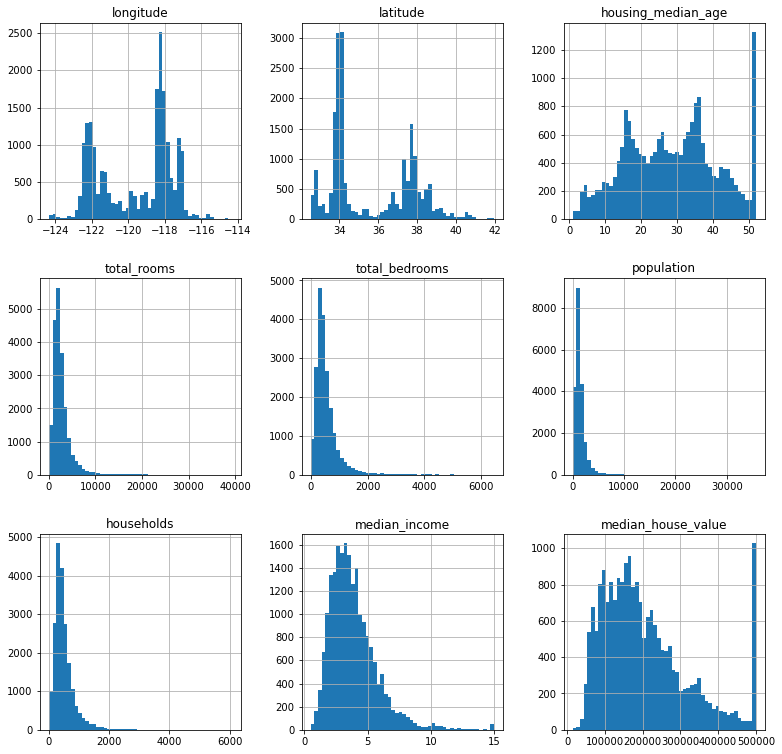

In [4]:
orig_df.hist(bins=50, figsize=(13, 13))

In [5]:
orig_df.info()
#total_bedrooms has 20433 values instead of 20640 = 207 missing values
#ocean_proximity is categorical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
corr_df = orig_df.copy()

In [7]:
corr_df['total_bedrooms'].fillna(corr_df['total_bedrooms'].mean(), inplace=True)

In [8]:
corr_df['total_bedrooms'].mean()

537.8705525375639

In [9]:
corr_df.ocean_proximity.describe()

count         20640
unique            5
top       <1H OCEAN
freq           9136
Name: ocean_proximity, dtype: object

In [10]:
import numpy as np
corr_df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [11]:
labels, uniques = pd.factorize(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'])
labels

array([0, 1, 2, 3, 4], dtype=int64)

In [12]:
ocean_mapper = {
    'NEAR BAY': 0,
    'NEAR OCEAN': 1,
    '<1H OCEAN' : 2,
    'ISLAND' : 3,
    'INLAND' : 4
    }

In [13]:
corr_df.replace({'ocean_proximity': ocean_mapper}, inplace=True) 

In [14]:
corr_df.ocean_proximity.value_counts()

2    9136
4    6551
1    2658
0    2290
3       5
Name: ocean_proximity, dtype: int64

# Data Exploration

In [15]:
X, y = corr_df.drop(columns=['median_house_value']), corr_df['median_house_value']

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [18]:
def fit(X, y, alpha):
    w = np.zeros(X.shape[1])
    w = 2 * X.T * (X * w - y) + 2 * alpha * w

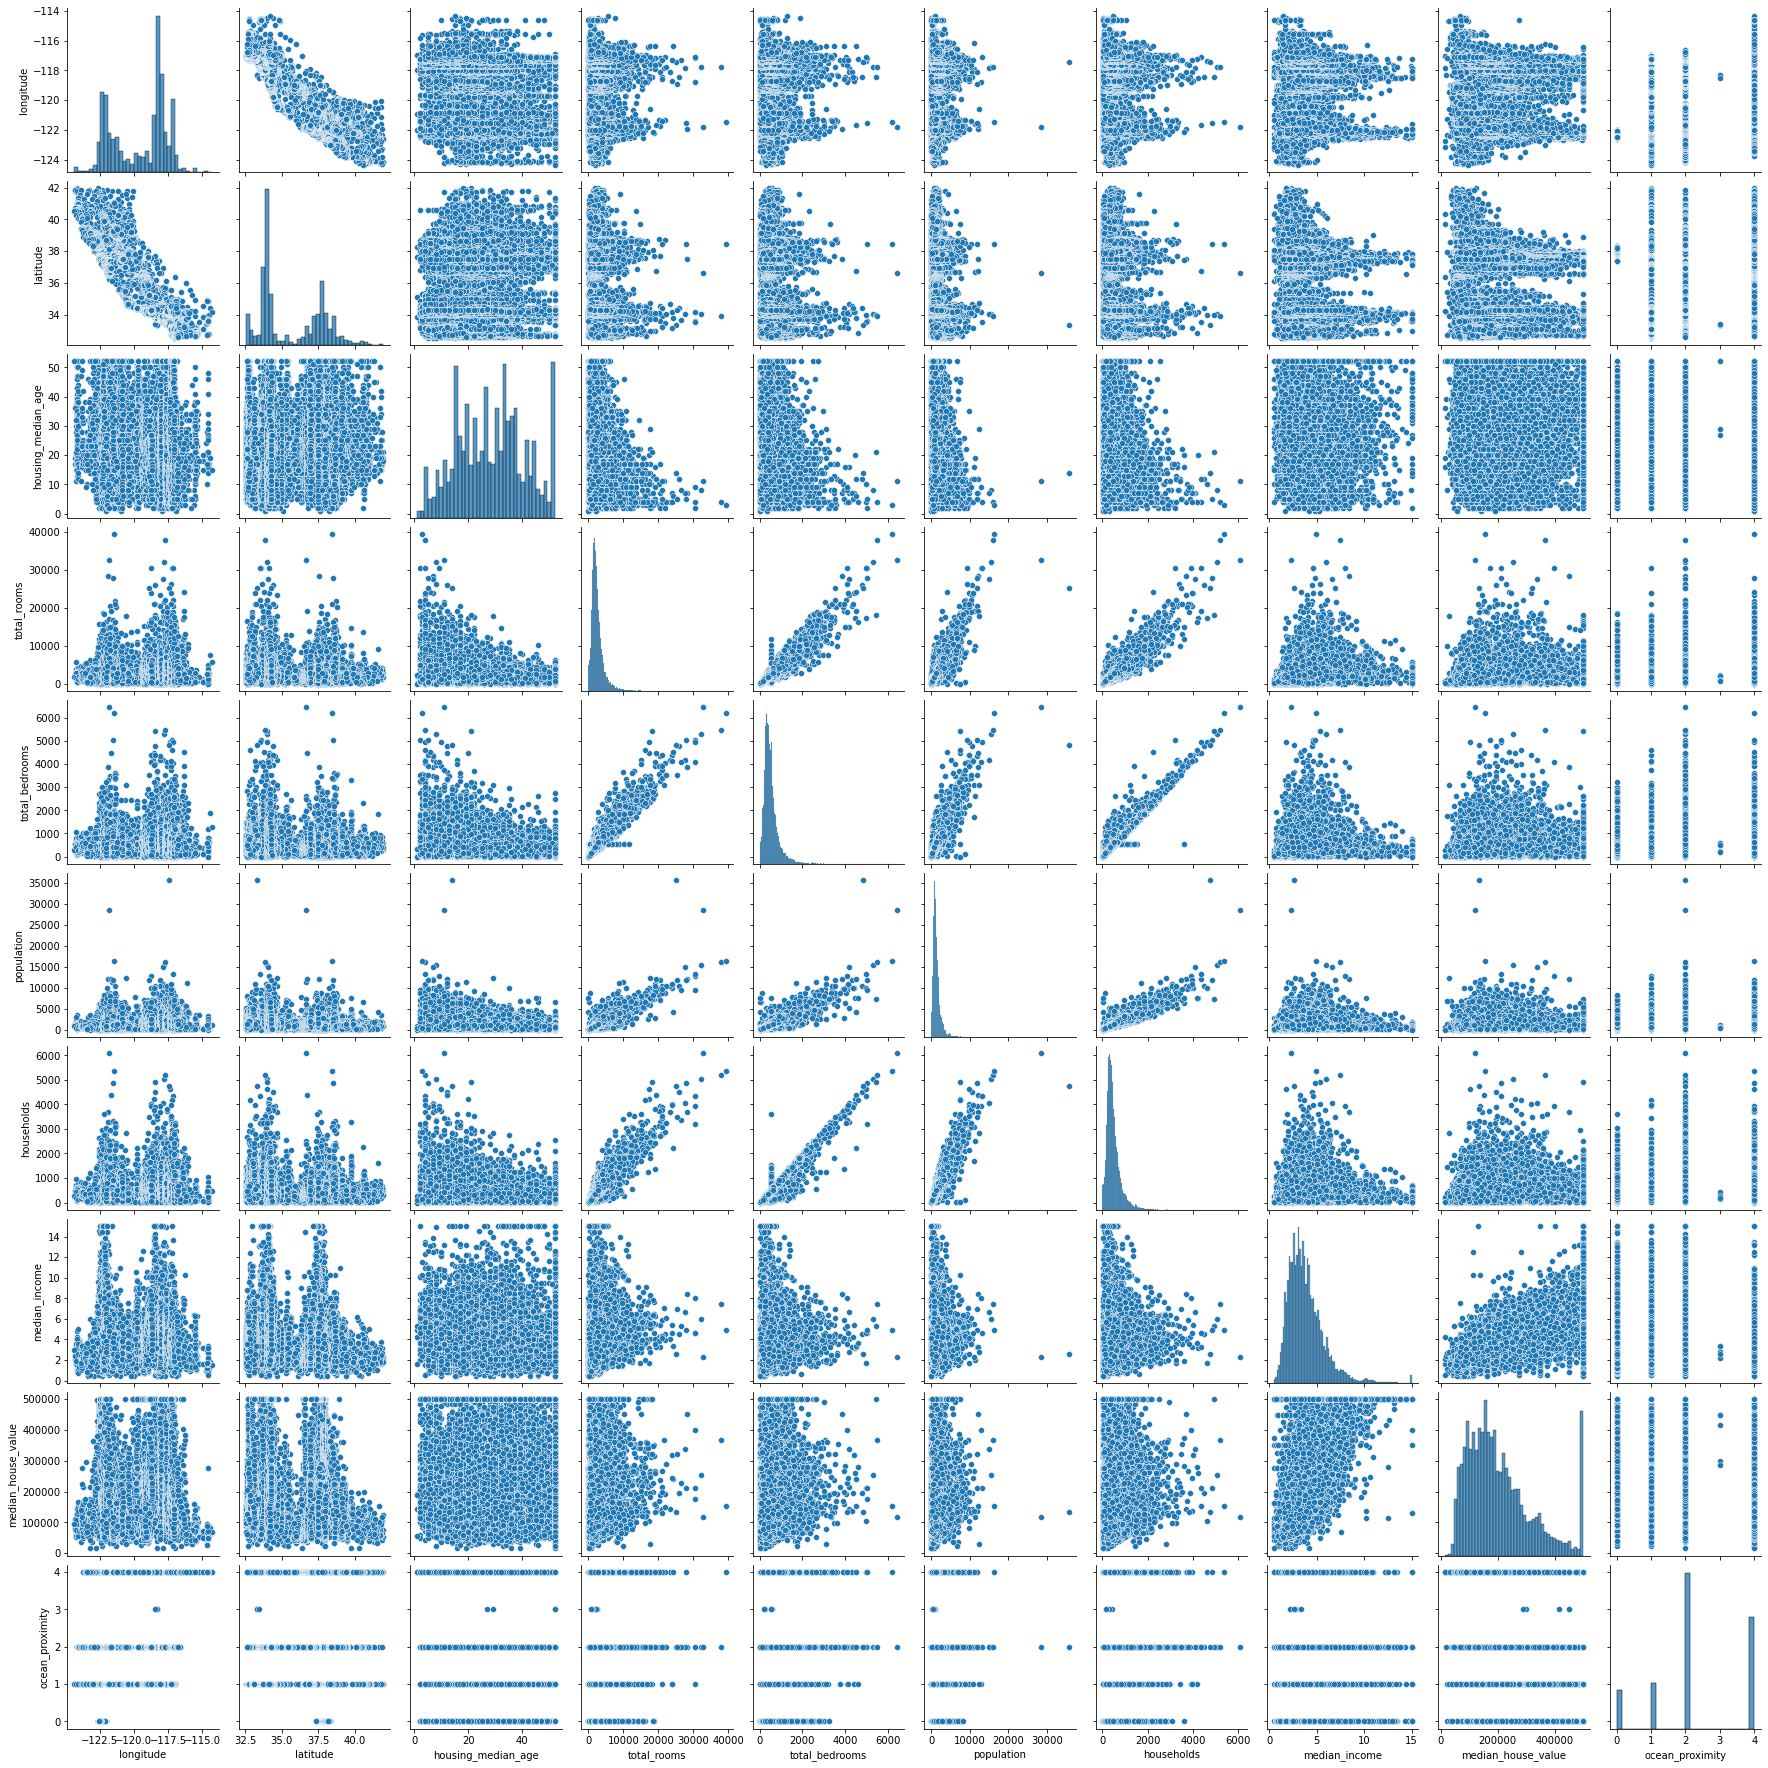

In [19]:
import seaborn as sns
sns.pairplot(corr_df)

In [20]:
corr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 1.6 MB


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

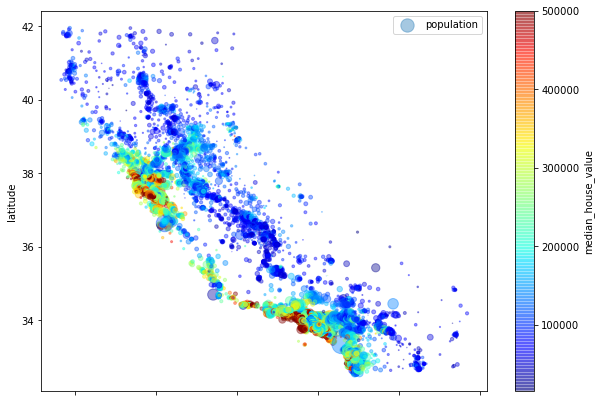

In [29]:
corr_df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
    s=corr_df['population']/100, label='population', figsize=(10,7), 
    c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)

In [21]:
orig_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [22]:
corr_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,2.284351
std,2.003532,2.135952,12.585558,2181.615252,419.266592,1132.462122,382.329753,1.899822,115395.615874,1.327262
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000,2.000000
50%,-118.490000,34.260000,29.000000,2127.000000,438.000000,1166.000000,409.000000,3.534800,179700.000000,2.000000
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000,4.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,4.000000


In [23]:
corr_df1.describe() #non è servito la stand_labels

NameError: name 'corr_df1' is not defined

## RIDGE

In [30]:
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

# SITO https://machinelearningmastery.com/ridge-regression-with-python/

In [31]:
# bisogna prima normalizzare i dati??
data = corr_df.values
X, y = data[:, :-1], data[:, -1]
# define model 
model = Ridge(alpha=1)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.663 (0.011)


# CODING http://localhost:8889/notebooks/OneDrive%20-%20Universit%C3%A0%20degli%20Studi%20di%20Milano/UNIVERSITA/DSE/Esami%20fatti/CODING/II%20modulo%20Coding/CDS-master1/CDS-master/Part_10.ipynb

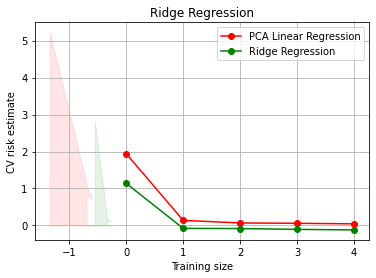

In [32]:
# aree grafico non funzionano
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import decomposition
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, validation_curve, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#from auxCode import *
%matplotlib inline
pca = decomposition.PCA(n_components=6)
pca.fit(X)
X_pca = pca.transform(X)

learner = LinearRegression(normalize=True)
RMS = 'neg_mean_squared_error'

lin_reg = LinearRegression(normalize=True)

l_train_size, l_train_score, l_val_score = learning_curve(lin_reg, X_pca, y, cv=5)
r_train_size, r_train_score, r_val_score = learning_curve(Ridge(normalize=True), X_pca, y,  cv=5)
plt.title('Ridge Regression')
l_val_score_mean = -np.mean(l_val_score, axis=1)
l_val_score_std = np.std(l_val_score, axis=1)
r_val_score_mean = -np.mean(r_val_score, axis=1)
r_val_score_std = np.std(r_val_score, axis=1)
plt.grid()
plt.fill_between(l_val_score_mean - l_val_score_std, l_val_score_mean + l_val_score_std, alpha=0.1,color="r")
plt.fill_between(r_val_score_mean - r_val_score_std,r_val_score_mean + r_val_score_std, alpha=0.1, color="g")
plt.plot(l_val_score_mean, 'o-', color="r",label="PCA Linear Regression")
plt.plot(r_val_score_mean, 'o-', color="g",label="Ridge Regression")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('CV risk estimate')
plt.show()

# SITO https://www.pluralsight.com/guides/linear-lasso-ridge-regression-scikit-learn

In [35]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
target_column = ['median_house_value'] 
predictors = list(set(list(corr_df.columns))-set(target_column))
corr_df[predictors] = corr_df[predictors]/corr_df[predictors].max()
print(corr_df.describe())
X = corr_df[predictors].values
y = corr_df[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape)
print(X_test.shape)

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean       0.961558      0.849389            0.550759      0.067034   
std        0.016112      0.050917            0.242030      0.055484   
min        0.919260      0.775685            0.019231      0.000051   
25%        0.949015      0.808820            0.346154      0.036820   
50%        0.952875      0.816687            0.557692      0.054095   
75%        0.979493      0.898927            0.711538      0.080061   
max        1.000000      1.000000            1.000000      1.000000   

       total_bedrooms    population    households  median_income  \
count    20640.000000  20640.000000  20640.000000   20640.000000   
mean         0.083455      0.039949      0.082134       0.258043   
std          0.065053      0.031738      0.062863       0.126654   
min          0.000155      0.000084      0.000164       0.033326   
25%          0.04608

In [36]:
#alpha_vals = np.linspace(0.01,1.0,2)
#rr = Ridge(alpha_vals)
rr = Ridge(alpha=1)
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print('R2 train: %.3f' % r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print('RMSE test: %.3f' % (np.sqrt(mean_squared_error(y_test,pred_test_rr))))
print('R2 test: %.3f' %r2_score(y_test, pred_test_rr))

RMSE train: 70137.279
R2 train: 0.628
RMSE test: 71698.359
R2 test: 0.619


In [ ]:
# GET INSPIRED https://rstudio-pubs-static.s3.amazonaws.com/520912_bbd05dad7ffe4eb08ab51ee2c5bd90bb.html